# The Jaynes-Cummings model

The Jaynes-Cummings model is a paradigmatic model from cavity QED, describing the interaction of a single two-state atom and a standing mode of the electromagnetic field.

$$
H_{JC} = \omega a^{\dagger} a + \frac{\omega_a}{2} \sigma_z + g (a \sigma_+ + a^\dagger \sigma_-)
$$

where $[a,a^\dagger]=1$ and $\sigma_z = |e\rangle\langle e| - |g\rangle\langle g|$, $\sigma_+ = |e\rangle\langle g|$ and $\sigma_- = (\sigma_+)^\dagger$.

In this notebook you will use QuTiP to simulate time evolution under this simple Hamiltonian.

You can find more information about QuTiP at [qutip.org](qutip.org), including many examples and tutorials: http://qutip.org/tutorials.html.

## Defining operators and states

In QuTip convenient functions already exist to create the operators we need to define $H_{JC}$.

Operators and states for a harmonic oscillator are defined using a truncated number (or Fock) basis. The number basis is just the eigenbasis of the number operator $a^\dagger a$, i.e., $a^\dagger a |n\rangle = n|n\rangle$. Any state in the harmonic oscillator Hilbert space can be written

$$
|\psi\rangle = \sum_{n=0}^\infty \psi_n |n\rangle.
$$

In QuTiP this state is represented by truncating the sum over n at some $n_\text{max}$ and representing $[\psi_n]$ as a vector. For example, the Fock state $|2\rangle$ is represented as

$$
\left(
\begin{array}{c}
0 \\
0 \\
1 \\
0 \\
\vdots \\
0 \\
\end{array}
\right)
$$

Similarly, any operator can be written

$$
A = \sum_{n,m=0}^\infty A_{n,m} |n\rangle\langle m|,
$$

which is represented in QuTip by a square matrix $[A_{n,m}]$ with $n,m=0,\dots,n_\text{max}$. Of course, this truncated Hilbert space only approxiamte the true Hilbert space, and we have to be careful to check that the truncation is valid. For example, the annihilatin operator is represented as

$$
a = \left(
\begin{array}{cccccc}
0 & \sqrt{1} & 0 & 0 & \dots & 0 \\
0 & 0 & \sqrt{2} & 0 & \dots & 0 \\
0 & 0 & 0 & \sqrt{3} & \dots & 0 \\
  &   & \vdots\\
0 & 0 & 0 & 0        & \dots & \sqrt{n_\text{max}-1} \\
\end{array}
\right)
$$

QuTiP conveniently has pre-defined functions for defining Fock states, creation and annihilation operators for a specified truncation, as shown in the following example.

Execute the cell by pressing shift+enter.

In [1]:
import qutip as qt

nmax = 5  # truncation parameter - truncate hilbert space to n=5

psi = qt.basis(nmax, 2)  # Fock state |2> in a truncated Hilbert space of dimension nmax
print(psi)

a = qt.destroy(nmax)  # annihilation operator
print(a)

ad = a.dag()  # the method .dag() takes the Hermitian conjuagate of any Qobj - creation operator
print(ad)

# compute a|psi> and normalize
psi = a*psi
psi = psi/psi.norm()
print(psi)

Quantum object: dims = [[5], [1]], shape = (5, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [1.]
 [0.]
 [0.]]
Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = False
Qobj data =
[[0.         1.         0.         0.         0.        ]
 [0.         0.         1.41421356 0.         0.        ]
 [0.         0.         0.         1.73205081 0.        ]
 [0.         0.         0.         0.         2.        ]
 [0.         0.         0.         0.         0.        ]]
Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = False
Qobj data =
[[0.         0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.        ]
 [0.         1.41421356 0.         0.         0.        ]
 [0.         0.         1.73205081 0.         0.        ]
 [0.         0.         0.         2.         0.        ]]
Quantum object: dims = [[5], [1]], shape = (5, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]
 [0.]
 [0.]]


As you can see, QuTiP's `Qobj` class contains various useful information besides the raw data (vector/matrix) representing the state/operator, such as a `type` attribute, and a `dims` attribute. 

(The `dims` attribute keeps track of the dimensions of the "input" and "output" Hilbert space of a linear operator. It is needed for QuTiP to keep track of tensor products.)

QuTiP also has convenient funtions for defining operators acting on a two-level system:

In [2]:
sz = qt.sigmaz() # Pauli-Z matrix
sp = qt.sigmap() # Two-level raising operator
sm = qt.sigmam() # Two-level lowering operator

print(sz)
print(sp)
print(sm)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0. 1.]
 [0. 0.]]
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0. 0.]
 [1. 0.]]


Beware of the following convention: In qutip `qt.basis(2, 0)` is the $+1$ eigenstate of `qt.sigmaz()`. In other words, `qt.basis(2, 0)` will represent the excited state and `qt.basis(2, 1)` the ground state of the two-level atom in $H_{JC}$. The following example illustrates the point (and shows you how to compute expectation values):

In [3]:
ground = qt.basis(2, 1) # 2 = num dimensions and 1 is integer corresponding to desired state
excited = qt.basis(2, 0)

# Compute expectation value of sigma-z in ground and excited state:
print(qt.expect(sz, ground))
print(qt.expect(sz, excited))

-1.0
1.0


We now know how to create operators acting on a truncated Fock space and on a two-level system. We are almost ready to define $H_{JC}$. The only missing ingredient is how to define tensor products. In $H_{JC}$ above we have used the standard convention of suppressing tensor products in the noation. Writing it all out we have

$$
H_{JC} = \omega a^{\dagger} a \otimes I + \frac{\omega_a}{2} I\otimes \sigma_z + g (a \otimes \sigma_+ + a^\dagger \otimes \sigma_-)
$$

with the convention that the oscillator is the left factor in the tensor product. In qutip, identity operators can be defined with `qt.identity(dim)` where `dim` is the Hilbert space dimension. A tensor product of two operators `A` and `B` can be computed through `qt.tensor(A, B)`. Similarly a tensor product of two states `psi` and `phi` is computed by `qt.tensor(psi, phi)`. For example, the operator $a\otimes I$ can be defined through:

In [41]:
nmax = 5
a = qt.tensor(qt.destroy(nmax), qt.identity(2))  # annihilation operator acting on the oscillator (identity on atom)
n = a.dag() * a  # number operator on oscillator (identity on atom)
print(a)

Quantum object: dims = [[5, 2], [5, 2]], shape = (10, 10), type = oper, isherm = False
Qobj data =
[[0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.41421356 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.41421356
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.73205081 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         1.73205081 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         2.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         2.        ]
 [0.         0.         0.         0.

### Exercise 1:

Use qutip to define $H_{JC}$ as well as an initial state $|\psi_0\rangle = |0,e\rangle$ where the oscillator is in the ground state and the atom is in the excited state.

Use the following parameters:
$$
\omega = \omega_a = 10,\\
g = 1
$$

Using a truncation of `nmax=3` you should get the following output for the Hamiltonian and initial state:

```
print(HJC)
Quantum object: dims = [[3, 2], [3, 2]], shape = (6, 6), type = oper, isherm = True
Qobj data =
[[ 5.          0.          0.          1.          0.          0.        ]
 [ 0.         -5.          0.          0.          0.          0.        ]
 [ 0.          0.         15.          0.          0.          1.41421356]
 [ 1.          0.          0.          5.          0.          0.        ]
 [ 0.          0.          0.          0.         25.          0.        ]
 [ 0.          0.          1.41421356  0.          0.         15.        ]]
```

```
print(psi0)
Quantum object: dims = [[3, 2], [1, 1]], shape = (6, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
```

Insert your solution below (you can add additional cells using the "+" button in the menubar).

In [26]:
w = wa = 10
g = 1
nmax = 3

ground = qt.basis(2, 1) # atom ground state
excited = qt.basis(2, 0) # atom excited state

psi0 = qt.tensor(qt.basis(nmax, 0), excited)
ida = qt.identity(2) # identity on atom
idr = qt.identity(nmax) # identity on resonator
a = qt.tensor(qt.destroy(nmax), ida) # annihilation operator

sz = qt.tensor(idr, qt.sigmaz()) # Pauli z - tensor product with identity to scale up the dimensions to match
sp = qt.tensor(idr, qt.sigmap()) # atom raising operator
sm = qt.tensor(idr, qt.sigmam()) # atom lowering operator


HJC = w * a.dag() * a + wa*sz/2 + g*(a * sp + a.dag() * sm)
print(HJC)
print(psi0)


Quantum object: dims = [[3, 2], [3, 2]], shape = (6, 6), type = oper, isherm = True
Qobj data =
[[ 5.          0.          0.          1.          0.          0.        ]
 [ 0.         -5.          0.          0.          0.          0.        ]
 [ 0.          0.         15.          0.          0.          1.41421356]
 [ 1.          0.          0.          5.          0.          0.        ]
 [ 0.          0.          0.          0.         25.          0.        ]
 [ 0.          0.          1.41421356  0.          0.         15.        ]]
Quantum object: dims = [[3, 2], [1, 1]], shape = (6, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


# Time-evolution

Now that we have constructed $H_{JC}$ and an initial state, the next step is to evolve the system in time, i.e., solve the Schrödinger equation. Again, QuTiP makes this easy for us.

The Schrödinger equation can be solved in qutip using the function `qt.sesolve` (for "Schrödinger Equation Solve"). To figure out the syntax of this function let's have a look at its docstring. The docstring of any python function can be pritned out in a notebook by typing the name of the function followed by a question mark. Execute the following command, and a help box should pop up:

In [18]:
qt.sesolve?

Signature:
qt.sesolve(
    H,
    psi0,
    tlist,
    e_ops=None,
    args=None,
    options=None,
    progress_bar=None,
    _safe_mode=True,
)
Docstring:
Schrödinger equation evolution of a state vector or unitary matrix for a
given Hamiltonian.

Evolve the state vector (``psi0``) using a given Hamiltonian (``H``), by
integrating the set of ordinary differential equations that define the
system. Alternatively evolve a unitary matrix in solving the Schrodinger
operator equation.

The output is either the state vector or unitary matrix at arbitrary points
in time (``tlist``), or the expectation values of the supplied operators
(``e_ops``). If ``e_ops`` is a callback function, it is invoked for each
time in ``tlist`` with time and the state as arguments, and the function
does not use any return values. ``e_ops`` cannot be used in conjunction
with solving the Schrodinger operator equation

Parameters
----------

H : :class:`~Qobj`, :class:`~QobjEvo`, list, or callable
    System Hamilto

Alternatively, the same thing can be accomplished calling `help(functionname)`

In [27]:
help(qt.sesolve)

Help on function sesolve in module qutip.sesolve:

sesolve(H, psi0, tlist, e_ops=None, args=None, options=None, progress_bar=None, _safe_mode=True)
    Schrodinger equation evolution of a state vector or unitary matrix
    for a given Hamiltonian.
    
    Evolve the state vector (`psi0`) using a given
    Hamiltonian (`H`), by integrating the set of ordinary differential
    equations that define the system. Alternatively evolve a unitary matrix in
    solving the Schrodinger operator equation.
    
    The output is either the state vector or unitary matrix at arbitrary points
    in time (`tlist`), or the expectation values of the supplied operators
    (`e_ops`). If e_ops is a callback function, it is invoked for each
    time in `tlist` with time and the state as arguments, and the function
    does not use any return values. e_ops cannot be used in conjunction
    with solving the Schrodinger operator equation
    
    Parameters
    ----------
    
    H : :class:`qutip.qobj`, :

As you can see from the docstring, `sesolve` takes three mandatory arguments, `H`, `psi0` and `tlist` and has three optional additional arguments `e_ops`, `args`, `options` and `progress_bar`. Let's ignore the optional arguments for now.

These mandatory arguments should be fairly self-explanator: `H` is the system Hamiltonian, `psi0` is the initial states, and `tlist` is a list for which you want to return the solution to the Schrödinger equation. In other words, the returned solution is $\psi(t)$ for $t \in $`tlist`. The function returns a variable `output` which contains the solution and various other information. As usual, you can find out more by calling `help(output)` as shown below.

Lets try a simple example with just a two-level system (no harmonic oscillator) to illustrate the basic functionality of `sesolve`:

In [27]:
import numpy as np  # import numpy, a convenient package for dealing with arrays


H = qt.sigmax()  # Pauli-X operator
psi0 = qt.basis(2, 1)  # ground state
tlist = np.linspace(0, 10, 100)  # a list of times between 0 and 10 
                                 # use np.linspace? or help(np.linspace) to find out more

output = qt.sesolve(H, psi0, tlist)  # solve the Schrödinger equation

help(output)  # have a look at the attributes of the returned output

Help on Result in module qutip.solver object:

class Result(builtins.object)
 |  Class for storing simulation results from any of the dynamics solvers.
 |  
 |  Attributes
 |  ----------
 |  
 |  solver : str
 |      Which solver was used [e.g., 'mesolve', 'mcsolve', 'brmesolve', ...]
 |  times : list/array
 |      Times at which simulation data was collected.
 |  expect : list/array
 |      Expectation values (if requested) for simulation.
 |  states : array
 |      State of the simulation (density matrix or ket) evaluated at ``times``.
 |  num_expect : int
 |      Number of expectation value operators in simulation.
 |  num_collapse : int
 |      Number of collapse operators in simualation.
 |  ntraj : int/list
 |      Number of trajectories (for stochastic solvers). A list indicates
 |      that averaging of expectation values was done over a subset of total
 |      number of trajectories.
 |  col_times : list
 |      Times at which state collpase occurred. Only for Monte Carlo solv

Let's have a look at the solution and plot an expectation value.

As indicated by the `help` function, the solution $\psi(t)$ is saved as a list in the `states` attribute of the `output`.

To compute an expectation value, use a call to `qt.expect(A, states)`. If `states` is a list of states this will return a list of expectation values of `A`, i.e., $\langle \psi(t)|A|\psi(t) \rangle$, evaluated at the times given in `tlist`.

In [29]:
psit = output.states  # the solution psi(t) is saved as a list in the `states` attribute

sz_exp = qt.expect(qt.sigmaz(), psit)  # expectation values of sz evaluated at the times given by `tlist`
print(sz_exp)

[-1.         -0.97966324 -0.91948013 -0.82189857 -0.69088756 -0.53177579
 -0.3510349  -0.15601625  0.04534808  0.24486795  0.43442821  0.60631884
  0.75354841  0.87012859  0.95131766  0.99381332  0.99588712  0.95745468
  0.88007921  0.76690787  0.62254375  0.45285867  0.26475429  0.06588149
 -0.13567091 -0.33170513 -0.51424779 -0.67587427 -0.81001063 -0.91120109
 -0.97532984 -0.99978853 -0.9835823  -0.92737033 -0.83343897 -0.70560878
 -0.54907906 -0.37021643 -0.17629587  0.02479521  0.22487778  0.41581382
  0.58983733  0.73987014  0.85980992  0.94477826  0.9913192   0.99753971
  0.96318677  0.88965766  0.77994308  0.63850553  0.4710978   0.28452892
  0.08638732 -0.11526793 -0.31223484 -0.49650212 -0.660575   -0.79778003
 -0.90253662 -0.97058393 -0.99915421 -0.98708537 -0.9348683  -0.84462688
 -0.72003156 -0.56615011 -0.38924141 -0.19650096  0.00423183  0.20479249
  0.39702355  0.57310633  0.72587894  0.84912758  0.93783928  0.9884058
  0.99877041  0.9685115   0.89885984  0.79264843  0.

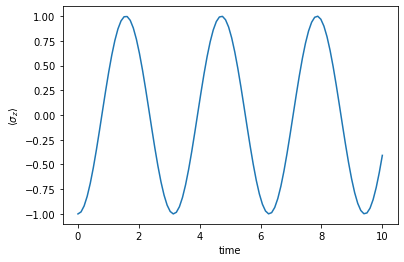

In [31]:
import matplotlib.pyplot as plt  # to plot things we need to import this library

# use the following command to tell Jupyter to plot things inline 
# in the notebook rather than open an external window
%matplotlib inline

plt.plot(tlist, sz_exp)
plt.xlabel(r'time')
plt.ylabel(r'$\langle \sigma_z \rangle$')
plt.show()

Question: What does the above time evolution looks like on the Bloch sphere?

### Exercise 2:

Returning to the Jaynes-Cumming Hamiltonian $H_{JC}$ you defined above, solve the Schrödinger equation the initial state $|\psi_0\rangle = |0,g\rangle$ for a set of times between $t=0$ and $t=10$, and plot the following expectation values:

$$
\langle a^\dagger a \rangle \\
\langle \sigma_z \rangle
$$


Once you have found the solution using `qt.sesolve` below is an example showing how to make a figure with multiple subpanels.

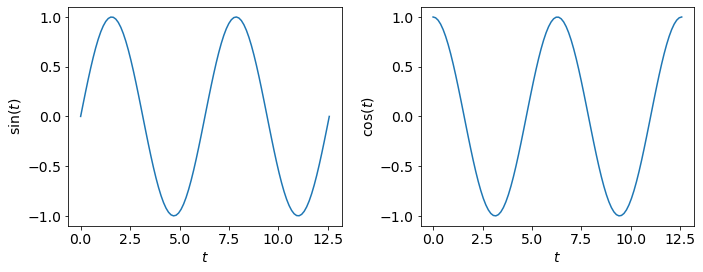

In [32]:
fig = plt.figure(figsize=(10, 4))  # create a new figure with desired size
plt.rc('font', size=14)  # Use a larger font size than the default 10pt

ax = fig.add_subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
bx = fig.add_subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2

tlist = np.linspace(0, 4*np.pi, 100)
ax.plot(tlist, np.sin(tlist))
bx.plot(tlist, np.cos(tlist))

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$\sin(t)$')
bx.set_xlabel(r'$t$')
bx.set_ylabel(r'$\cos(t)$')

plt.tight_layout()

Use a similar approach to plot your soluton for $\langle a^\dagger a\rangle$ and $\langle \sigma_z \rangle$ in two panels.

Insert your solution below.

In [56]:
tlist = np.linspace(0, 10, 100)
psi0 = qt.tensor(qt.basis(nmax, 0), excited)
output = qt.sesolve(H=HJC, psi0=psi0, tlist=tlist)

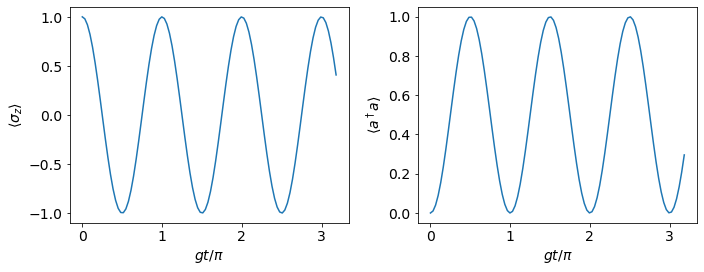

In [58]:
fig = plt.figure(figsize=(10, 4))  # create a new figure with desired size
plt.rc('font', size=14)  # Use a larger font size than the default 10pt

ax = fig.add_subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
bx = fig.add_subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2

tlist = np.linspace(0, 4*np.pi, 100)
ax.plot(output.times/np.pi, qt.expect(sz, output.states))
bx.plot(output.times/np.pi, qt.expect(a.dag() * a, output.states))


ax.set_xlabel(r'$gt/\pi$')
ax.set_ylabel(r'$\langle \sigma_z \rangle$')
bx.set_xlabel(r'$gt/\pi$')
bx.set_ylabel(r'$\langle a^\dagger a \rangle$')

plt.tight_layout()

Question: What do you think the state of the oscillator+atom system is at $gt=\pi/4, \pi/2, \pi$?

# Creating functions for conveniently changing parameters


We are often interested in how the properties of a system change as we vary the parameters of a model. For this purpose it is convenient to define a python function that returns the solution for a set of parameters. The below example shows how to do this for the Jaynes Cummings model.

Play around with different choices of parameters and see how the solution changes

In [59]:
def jc_model(w, wa, g, nmax=5):
    """
    This function solves the Schrödinger equation for the JC model with
    |psi0> = |0,e> as an initial state and the following parameters:
    
    w = oscillator frequency
    wa = atom frequency
    g = coupling strength
    nmax = Hilbert space truncation (5 by default)
    
    Instead of returning the full output, the function retuns expectation values
    <sigma_z> and <a* a>
    """

    idr = qt.identity(nmax)  # identiy operator on oscillator ("r" for "resonator")
    ida = qt.identity(2)  # identity operator on atom
    
    ground = qt.basis(2, 1)  # atom ground state
    excited = qt.basis(2, 0)  # atom excited state
    
    a = qt.tensor(qt.destroy(nmax), ida)  # annihilation operator
    sz = qt.tensor(idr, qt.sigmaz())  # Pauli-z
    sm = qt.tensor(idr, qt.sigmam())  # atom lowering operator
    sp = qt.tensor(idr, qt.sigmap())  # atom raising operator
    
    HJC = w*a.dag()*a + wa*sz/2 + g * (a * sp + a.dag() * sm)
    psi0 = qt.tensor(qt.basis(nmax, 0), excited)
    
    tlist = np.linspace(0, 10, 1000) 
    output = qt.sesolve(HJC, psi0, tlist)  # solve the Schrödinger equation 
    
    return tlist, qt.expect(sz, output.states), qt.expect(a.dag()*a, output.states)

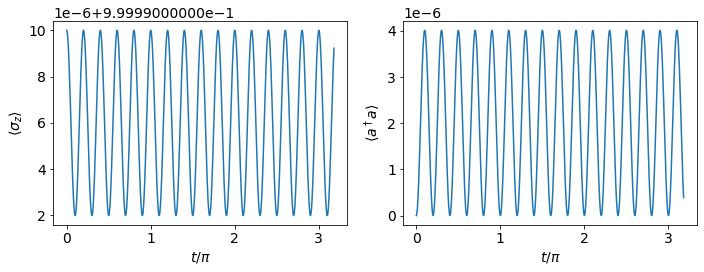

In [64]:
# Solve for a parameter set and plot the solution

nmax = 10

w = 0.01
wa = 10
g = 0.01
tlist, sz_exp, ada_exp = jc_model(w, wa, g, nmax=nmax)

fig = plt.figure(figsize=(10, 4))  # create a new figure with desired size
plt.rc('font', size=14)  # Use a larger font size than the default 10pt

ax = fig.add_subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
bx = fig.add_subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2

ax.plot(tlist/np.pi, sz_exp)
bx.plot(tlist/np.pi, ada_exp)

ax.set_xlabel(r'$t/\pi$')
ax.set_ylabel(r'$\langle \sigma_z \rangle$')
bx.set_xlabel(r'$t/\pi$')
bx.set_ylabel(r'$\langle a^\dagger a \rangle$')

plt.tight_layout()